In [253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import datetime
from kaggle.competitions import nflrush
import tqdm
import re
import matplotlib.patches as patches

from string import punctuation

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_style('darkgrid')
mpl.rcParams['figure.figsize'] = [15,10]

In [254]:
%load_ext autoreload
%aimport utils
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [255]:
source_train = pd.read_csv('data/train.csv', dtype={'WindSpeed': 'object'})
source_train.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2506353,Derrick Johnson,56,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,245,11/22/1982,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2530794,Ron Parker,38,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,206,08/17/1987,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


In [256]:
%%time
df = utils.preprocess_features(source_train)

CPU times: user 34.3 s, sys: 5.81 s, total: 40.1 s
Wall time: 34.3 s


In [257]:
df.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,GameWeather,Temperature,Humidity,WindSpeed,ToLeft,TeamOnOffense,IsOnOffense,HomeOnOffense,TurfIsNatural,StadiumTypeShort,HomeField,Field_eq_Possession,HomePossesion,OffenseFormation_ACE,OffenseFormation_EMPTY,OffenseFormation_I_FORM,OffenseFormation_JUMBO,OffenseFormation_PISTOL,OffenseFormation_SHOTGUN,OffenseFormation_SINGLEBACK,OffenseFormation_WILDCAT,PlayerBMI,TimeDelta,PlayerAge,IsRusher,defense_DB,defense_DL,defense_LB,defense_OL,defense_QB,defense_RB,defense_TE,defense_WR,offense_DB,offense_DL,offense_LB,offense_OL,offense_QB,offense_RB,offense_TE,offense_WR,DefendersInTheBox_vs_Distance
0,2017090700,20170907000118,away,46.09,18.493333,1.69,1.13,0.40,4.572588,1.620015,496723,Eric Berry,29,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,212,1988-12-29 00:00:00+00:00,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,28.749228,1.0,28.692760,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0
1,2017090700,20170907000118,away,45.33,20.693333,0.42,1.35,0.01,3.623478,1.244420,2495116,Allen Bailey,97,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,288,1989-03-25 00:00:00+00:00,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,35.993600,1.0,28.457305,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0
2,2017090700,20170907000118,away,46.00,20.133333,1.22,0.59,0.31,3.194127,1.174083,2495493,Justin Houston,50,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,270,1989-01-21 00:00:00+00:00,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,33.744000,1.0,28.629790,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0
3,2017090700,20170907000118,away,48.54,25.633333,0.42,0.54,0.02,3.137578,2.868623,2506353,Derrick Johnson,56,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,245,1982-11-22 00:00:00+00:00,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,30.619556,1.0,34.795430,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0
4,2017090700,20170907000118,away,50.68,17.913333,1.82,2.43,0.16,3.362028,1.844638,2530794,Ron Parker,38,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,206,1987-08-17 00:00:00+00:00,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,27.935571,1.0,30.061685,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0


In [258]:
df.head().T

,0,1,2,3,4
GameId,2017090700,2017090700,2017090700,2017090700,2017090700
PlayId,20170907000118,20170907000118,20170907000118,20170907000118,20170907000118
Team,away,away,away,away,away
X,46.09,45.33,46,48.54,50.68
Y,18.4933,20.6933,20.1333,25.6333,17.9133
S,1.69,0.42,1.22,0.42,1.82
A,1.13,1.35,0.59,0.54,2.43
Dis,0.4,0.01,0.31,0.02,0.16
Orientation,4.57259,3.62348,3.19413,3.13758,3.36203
Dir,1.62001,1.24442,1.17408,2.86862,1.84464


In [259]:
df.isnull().sum(axis=0)[df.isnull().sum(axis=0)>0]

Orientation                         18
Dir                                 14
FieldPosition                     6424
DefendersInTheBox                   66
Temperature                      48532
Humidity                          6160
WindSpeed                        71632
StadiumTypeShort                 70620
DefendersInTheBox_vs_Distance       66
dtype: int64

In [260]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12*2, 6.33*2)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0,  alpha=0.5)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

In [261]:
def get_dx_dy(radian_angle, dist):
    dx = dist * np.cos(radian_angle)
    dy = dist * np.sin(radian_angle)
    return dx, dy

def show_play_std(play_id, train):
    df = train[train.PlayId == play_id]
    YardLine = df.YardLine.values[0]
    fig, ax = create_football_field(highlight_line=True,
                                    highlight_line_number=YardLine,
                                   )
    
    ax.scatter(df[df.IsOnOffense].X, df[df.IsOnOffense].Y, color='red', s=100, label='offense')
    ax.scatter(df[~df.IsOnOffense].X, df[~df.IsOnOffense].Y, color='blue', s=100, label='defense')
    rusher_row = df[df.IsRusher]
    ax.scatter(rusher_row.X, rusher_row.Y, color='yellow', s=50, label='rusher', zorder=999)
    yards_covered = rusher_row["Yards"].values[0]

    for (x, y, Dir, S) in zip(df.X, df.Y, df.Dir, df.S):       
        dx, dy = get_dx_dy(Dir, S)
        ax.arrow(x, y, dx, dy, length_includes_head=False, width=0.2, color='black', alpha=0.4, zorder=0)
    left = 'left' if df.ToLeft.sum() > 0 else 'right'
    plt.title(f'Play # {play_id} moving to {left}, yard distance is {yards_covered}, scrimage is {YardLine} ', fontsize=20)
    plt.legend()
    plt.show()

In [262]:
df[df.PlayId==20170910000081].head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,GameWeather,Temperature,Humidity,WindSpeed,ToLeft,TeamOnOffense,IsOnOffense,HomeOnOffense,TurfIsNatural,StadiumTypeShort,HomeField,Field_eq_Possession,HomePossesion,OffenseFormation_ACE,OffenseFormation_EMPTY,OffenseFormation_I_FORM,OffenseFormation_JUMBO,OffenseFormation_PISTOL,OffenseFormation_SHOTGUN,OffenseFormation_SINGLEBACK,OffenseFormation_WILDCAT,PlayerBMI,TimeDelta,PlayerAge,IsRusher,defense_DB,defense_DL,defense_LB,defense_OL,defense_QB,defense_RB,defense_TE,defense_WR,offense_DB,offense_DL,offense_LB,offense_OL,offense_QB,offense_RB,offense_TE,offense_WR,DefendersInTheBox_vs_Distance
1144,2017091000,20170910000081,away,38.40,35.373333,4.41,3.16,0.46,2.247635,4.560545,2495343,Buster Skrine,41,2017,25,1,892.0,BUF,2,10,BUF,0,0,79607,6.0,left,2017-09-10 17:03:37+00:00,2017-09-10 17:03:36+00:00,3,69,185,1989-04-26 00:00:00+00:00,Chattanooga,CB,BUF,NYJ,1,New Era Field,Orchard Park NY,2.0,65.0,53.0,6.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,0,1,0,27.316740,1.0,28.377032,False,5,4,2,0,0,0,0,0,0,0,0,0,0,1,2,2,0.6
1145,2017091000,20170910000081,away,34.88,24.803333,2.98,1.37,0.25,2.257758,4.525115,2495490,Muhammad Wilkerson,96,2017,25,1,892.0,BUF,2,10,BUF,0,0,79607,6.0,left,2017-09-10 17:03:37+00:00,2017-09-10 17:03:36+00:00,3,76,315,1989-10-22 00:00:00+00:00,Temple,DE,BUF,NYJ,1,New Era Field,Orchard Park NY,2.0,65.0,53.0,6.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,0,1,0,38.338816,1.0,27.886956,False,5,4,2,0,0,0,0,0,0,0,0,0,0,1,2,2,0.6
1146,2017091000,20170910000081,away,35.08,25.813333,3.60,0.98,0.42,3.256435,4.604528,2507590,Steve McLendon,99,2017,25,1,892.0,BUF,2,10,BUF,0,0,79607,6.0,left,2017-09-10 17:03:37+00:00,2017-09-10 17:03:36+00:00,3,75,310,1986-01-03 00:00:00+00:00,Troy,NT,BUF,NYJ,1,New Era Field,Orchard Park NY,2.0,65.0,53.0,6.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,0,1,0,38.743111,1.0,31.687093,False,5,4,2,0,0,0,0,0,0,0,0,0,0,1,2,2,0.6
1147,2017091000,20170910000081,away,37.71,23.263333,3.05,0.97,0.43,3.119602,4.503473,2533008,Demario Davis,56,2017,25,1,892.0,BUF,2,10,BUF,0,0,79607,6.0,left,2017-09-10 17:03:37+00:00,2017-09-10 17:03:36+00:00,3,74,248,1989-01-11 00:00:00+00:00,Arkansas State,ILB,BUF,NYJ,1,New Era Field,Orchard Park NY,2.0,65.0,53.0,6.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,0,1,0,31.837838,1.0,28.664506,False,5,4,2,0,0,0,0,0,0,0,0,0,0,1,2,2,0.6
1148,2017091000,20170910000081,away,36.52,11.413333,0.77,0.83,0.08,4.287576,1.702045,2533059,Morris Claiborne,21,2017,25,1,892.0,BUF,2,10,BUF,0,0,79607,6.0,left,2017-09-10 17:03:37+00:00,2017-09-10 17:03:36+00:00,3,71,192,1990-02-07 00:00:00+00:00,Louisiana State,CB,BUF,NYJ,1,New Era Field,Orchard Park NY,2.0,65.0,53.0,6.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,0,1,0,26.775640,1.0,27.591269,False,5,4,2,0,0,0,0,0,0,0,0,0,0,1,2,2,0.6


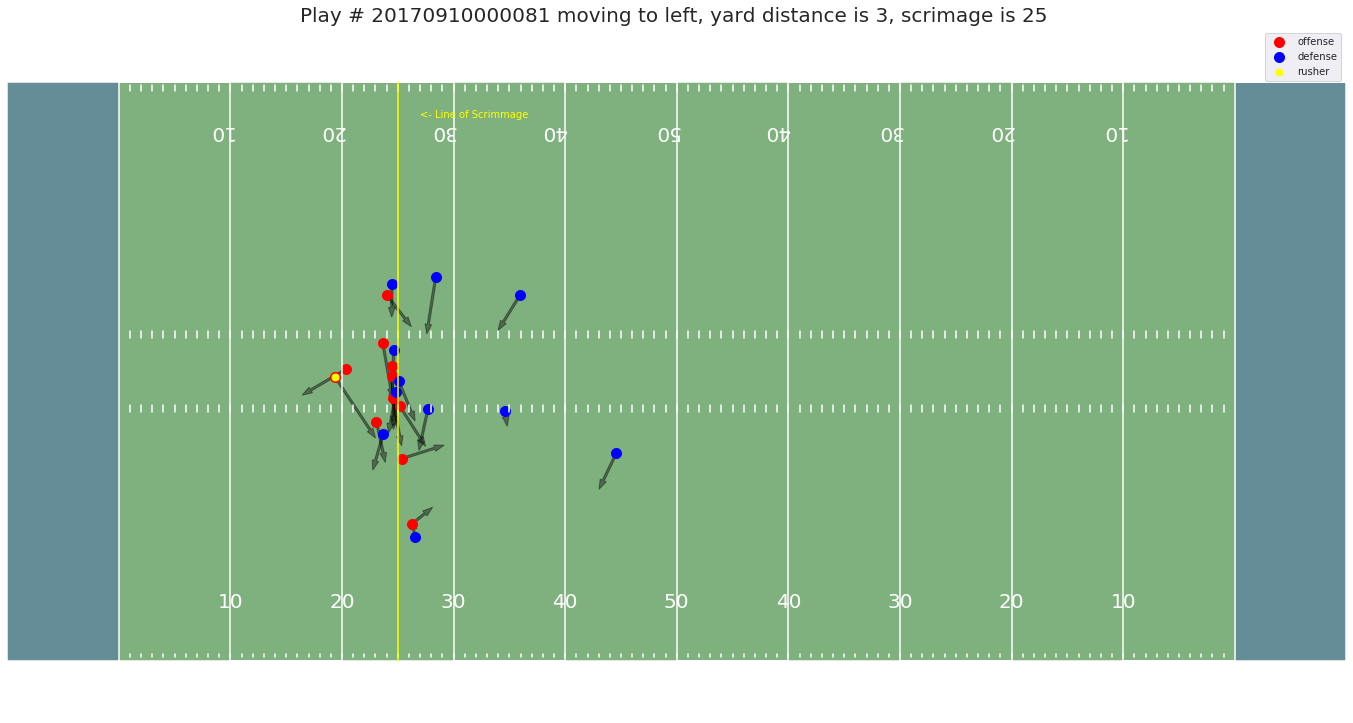

In [263]:
show_play_std(20170910000081, df)

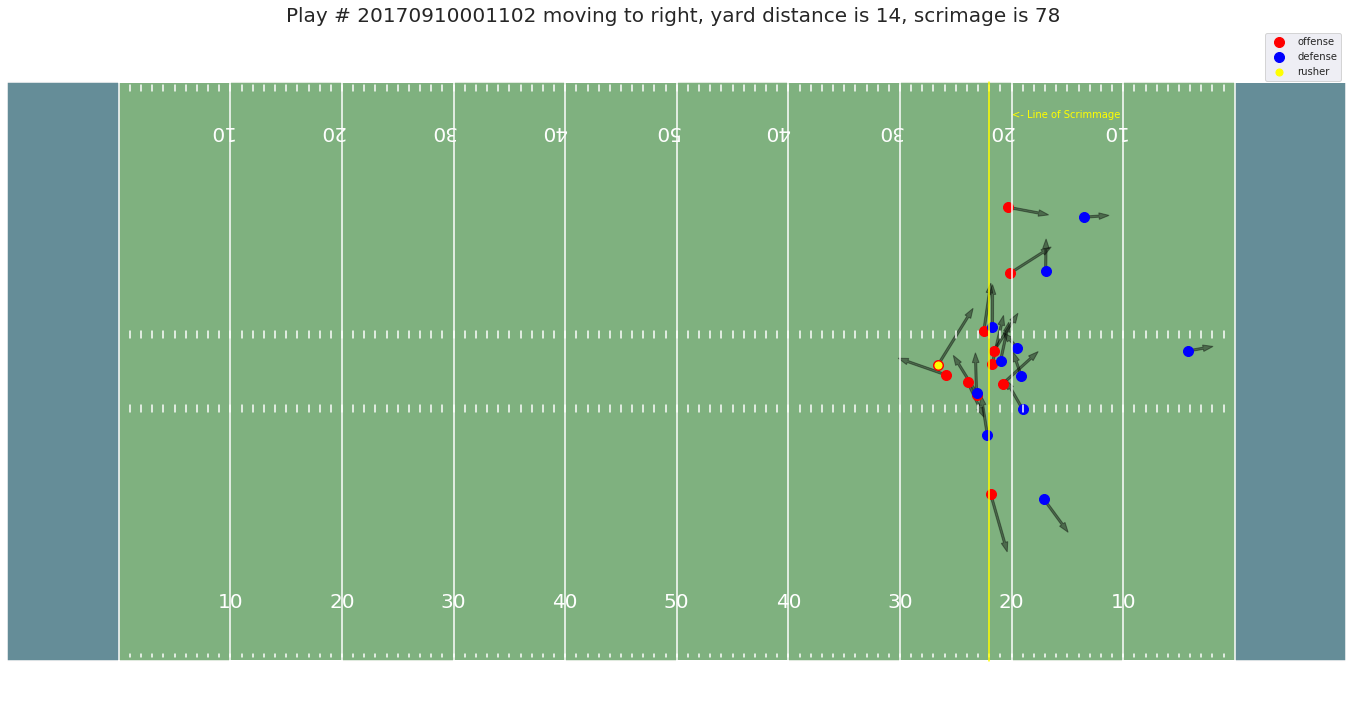

In [264]:
show_play_std(20170910001102, df)

# Get physics features

Use X, Y, direction and weight of players to make new features

Features:
* distance between Runner and QB
* distance from Runner to closest defender
* distance from Runner to defense centroid
* distance from Runner to offense centroid
* distance between offense and defense centroids
* Defense max(X) - min(X)
* Defense X std
* Offense max(X) - min(X)
* Offense X std
* min time to tackle runner
* runner speed vs closest defender speed
* runner speed vs average defenders speed
* scalar product between runner mov vector and closest defender mov vector
* scalar product between runner mov vector and average defenders mov vector
force(speed*mass):
* runner force vs closest defender force
* runner force vs average defender force

In [265]:
def get_play_phys_features(play_df):
    pass

In [266]:
play_df = df[df['PlayId'] == 20170910001102].copy()

cols = ['IsOnOffense', 'Position', 'IsRusher', 'X', 'Y', 'S', 'A', 'Dir', 'PlayerWeight'] # Using Dir as the direction of player
play_df = play_df[cols]
play_df['Force'] = play_df['A']*play_df['PlayerWeight']


offense_df = play_df[play_df.IsOnOffense]
rusher_row = offense_df[offense_df.IsRusher == True].iloc[0]
qb_row = offense_df[offense_df.Position == 'QB'].iloc[0]

offense_spread_x = offense_df.X.max()-offense_df.X.min()
offense_centroid_x =  offense_df.X.mean()
offense_x_std = offense_df.X.std()
offense_spread_y = offense_df.Y.max()-offense_df.Y.min()
offense_centroid_y =  offense_df.Y.mean()
offense_y_std = offense_df.Y.std()
offense_mean_force = offense_df.Force.mean()
offense_mean_dir = offense_df.Dir.mean()

defense_df = play_df[~play_df.IsOnOffense]
defense_spread_x = defense_df.X.max()-defense_df.X.min()
defense_centroid_x =  defense_df.X.mean()
defense_x_std = defense_df.X.std()
defense_spread_y = defense_df.Y.max()-defense_df.Y.min()
defense_centroid_y =  defense_df.Y.mean()
defense_y_std = defense_df.Y.std()
defense_mean_force = defense_df.Force.mean()
defense_mean_dir = defense_df.Dir.mean()

offense_centroid_pos = np.array([offense_centroid_x, offense_centroid_y])
defense_centroid_pos = np.array([defense_centroid_x, defense_centroid_y])
rusher_pos = rusher_row[['X', 'Y']].values[0]
qb_pos = qb_row[['X', 'Y']].values[0]

# Defender to rusher distances
defense_distances_to_runner = []
for row in defense_df.itertuples():
    pos = np.array([row.X, row.Y])
    defense_distances_to_runner.append(np.linalg.norm(rusher_pos-pos))
defense_df['dist_to_rusher'] = defense_distances_to_runner = np.array(defense_distances_to_runner)

defense_df['time_to_rusher'] = defense_df['S'] / defense_df['dist_to_rusher']

defender_dist_to_runner_min = defense_distances_to_runner.min()
defender_dist_to_runner_mean = defense_distances_to_runner.mean()
defender_dist_to_runner_std = defense_distances_to_runner.std()

defender_time_to_runner_min = defense_df['time_to_rusher'].min()
defender_time_to_runner_mean = defense_df['time_to_rusher'].mean()

# closest defenders
closest_defender = defense_df[defense_df.dist_to_rusher == defender_dist_to_runner_min].iloc[0]
closest_bytime_defender = defense_df[defense_df.time_to_rusher == defender_time_to_runner_min].iloc[0]

closest_defender_force_div_rusher_force = (closest_defender.Force/rusher_row.Force)
closest_bytime_defender_force_div_rusher_force = (closest_bytime_defender.Force/rusher_row.Force)

closest_bytime_defender_speed_div_rusher_speed = closest_bytime_defender.S/rusher_row.S
closest_bytime_defender_acceleration_div_rusher_acceleration = closest_bytime_defender.A/rusher_row.A
# Rusher distances
rusher_dist_to_qb = np.linalg.norm(rusher_pos-qb_pos)
rusher_dist_to_offense_centroid = np.linalg.norm(rusher_pos-offense_centroid_pos)
rusher_dist_to_defence_centroid = np.linalg.norm(rusher_pos-defense_centroid_pos)

closest_defender_force_div_rusher_force, closest_bytime_defender_force_div_rusher_force

/home/boris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/boris/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0.23555555555555557, 0.03872672672672673)

In [267]:
df.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,DefendersInTheBox,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,GameWeather,Temperature,Humidity,WindSpeed,ToLeft,TeamOnOffense,IsOnOffense,HomeOnOffense,TurfIsNatural,StadiumTypeShort,HomeField,Field_eq_Possession,HomePossesion,OffenseFormation_ACE,OffenseFormation_EMPTY,OffenseFormation_I_FORM,OffenseFormation_JUMBO,OffenseFormation_PISTOL,OffenseFormation_SHOTGUN,OffenseFormation_SINGLEBACK,OffenseFormation_WILDCAT,PlayerBMI,TimeDelta,PlayerAge,IsRusher,defense_DB,defense_DL,defense_LB,defense_OL,defense_QB,defense_RB,defense_TE,defense_WR,offense_DB,offense_DL,offense_LB,offense_OL,offense_QB,offense_RB,offense_TE,offense_WR,DefendersInTheBox_vs_Distance
0,2017090700,20170907000118,away,46.09,18.493333,1.69,1.13,0.40,4.572588,1.620015,496723,Eric Berry,29,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,212,1988-12-29 00:00:00+00:00,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,28.749228,1.0,28.692760,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0
1,2017090700,20170907000118,away,45.33,20.693333,0.42,1.35,0.01,3.623478,1.244420,2495116,Allen Bailey,97,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,288,1989-03-25 00:00:00+00:00,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,35.993600,1.0,28.457305,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0
2,2017090700,20170907000118,away,46.00,20.133333,1.22,0.59,0.31,3.194127,1.174083,2495493,Justin Houston,50,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,270,1989-01-21 00:00:00+00:00,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,33.744000,1.0,28.629790,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0
3,2017090700,20170907000118,away,48.54,25.633333,0.42,0.54,0.02,3.137578,2.868623,2506353,Derrick Johnson,56,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,75,245,1982-11-22 00:00:00+00:00,Texas,ILB,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,30.619556,1.0,34.795430,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0
4,2017090700,20170907000118,away,50.68,17.913333,1.82,2.43,0.16,3.362028,1.844638,2530794,Ron Parker,38,2017,35,1,854.0,NE,3,2,NE,0,0,2543773,6.0,left,2017-09-08 00:44:06+00:00,2017-09-08 00:44:05+00:00,8,72,206,1987-08-17 00:00:00+00:00,Newberry,FS,NE,KC,1,Gillette Stadium,"Foxborough, MA",1.0,63.0,77.0,8.0,True,home,False,1,False,1.0,True,True,True,0,0,0,0,0,1,0,0,27.935571,1.0,30.061685,False,6,2,3,0,0,0,0,0,0,0,0,0,0,1,1,3,3.0


# Assemble $(X, y)$ matrix

In [272]:
X_train = utils.make_x(df)
y_train = utils.make_y(X_train, df)

In [ ]:
# (train != df_preproc).sum(axis=0)

In [ ]:
# df_preproc[df_preproc.isnull().any(axis=1)].shape

In [ ]:
# train[train.isnull().any(axis=1)].shape

In [ ]:
# train[(train != df_preproc).any(axis=1)].head()

In [ ]:
# df_preproc[(train.dropna() != df_preproc.dropna()).any(axis=1)].head()

In [ ]:
# (df_preproc.dropna() != train.dropna()).sum(axis=0)

In [ ]:
# df_preproc.dropna().shape, train.dropna().shape

In [ ]:
# y_df = pd.DataFrame(y_train)
# y_df.head()

In [ ]:
# X_df = pd.DataFrame(X_train)
# X_df.head()

In [ ]:
# X_df.to_csv('data/x_train.csv', index=None)

In [ ]:
# y_df.to_csv('data/y_train.csv', index=None)